# GANs

In this notebook, we are going to create a generative adversarial network (GAN) from scratch! Specifically, we will build and train a GAN that can generate hand-written images of digits (0-9). 

Generative Adversarial Networks are considered the state of the art for the generation of photorealistic images. 

Take a look at the images below. Can you distinguish which images are real and which ones are fakes?

<table>
<tr>
<th>
    <img src='./this_person_does_not_exist/person1.jpeg' height=200 width=200/>
</th>

<th>
    <img src='./this_person_does_not_exist/person2.jpeg' height=200 width=200/>
</th>
<th>
    <img src='./this_person_does_not_exist/person3.jpeg' height=200 width=200/>
</th>
</tr>
<tr>
<th>
    <img src='./this_person_does_not_exist/person4.jpeg' height=200 width=200/>
</th>
<th>
    <img src='./this_person_does_not_exist/person5.jpeg' height=200 width=200/>
</th>
<th>
    <img src='./this_person_does_not_exist/person6.jpeg' height=200 width=200/>
</th>
</tr>
</table>

Actually all images are fake... Those images were created by a GAN named StyleGAN2 (Dec 2019) - Karras et al. and Nvidia

Source: https://thispersondoesnotexist.com/

Also see: https://thisxdoesnotexist.com/


## How does a GAN work?

GANs are a hot topic that is evolving very fast. However, we will explore the basic concept of GANs as proposed by Ian Goodfellow in 2014. [Original paper in GANs](https://arxiv.org/pdf/1406.2661.pdf)

In a GAN the **discriminator** (also called sometimes the **critic**) is a binary classifier that will be trained to distinguish if an image is fake or real. The **generator** will be trying to generate images that fool the **discriminator**. At the beginning both the **generator** $G$ and **discriminator** $D$ will be taking random guesses. Both $G$ and $D$ will be learning from each other's feedback. The input of the $G$ will be a random vector $z$. 

<img src='Gan.png' height=400 width=400 />

In a more formal way, $G$ and $D$ will be playing a MiniMax game trying to get better than their adversary.

$min_D max_G \{ -E_{x \sim \text{Data}} log D(\mathbf x) - E_{z \sim \text{Noise}} log(1 - D(G(\mathbf z))) \}$




## Import Libraries
We will begin by importing some useful packages and the MNIST dataset which will be used to build and train our GAN.

In [35]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST  # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from deep_ml_curriculum.torchsummaryX import summary

torch.manual_seed(2020)  # Set for testing purposes, please do not change!

Function for visualizing images: Given a tensor of images, number of images, and size per image, plots and prints the images in a uniform grid.

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## MNIST Dataset

The training images your discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits (28x28 pixels), from 0 to 9, like these. Additionally, these images are also in black-and-white so only one dimension, or "color channel", is needed to represent them. Colored images are usually in the RGB space and need 3 channels to represent them.

![MNIST Digits](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Source Image:[MNIST Example](https://en.wikipedia.org/wiki/MNIST_database#/media/File:MnistExamples.png)
License: [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0)

#### Batches
While you could train your model after generating one image, it is extremely inefficient and leads to less stable training. In GANs, and in machine learning in general, you will process multiple images per training step. These are called batches.

This means that your generator will generate an entire batch of images and receive the discriminator's feedback on each before updating the model. The same goes for the discriminator, it will calculate its loss on the entire batch of generated images as well as on the reals before the model is updated.


# Generator

The first step is to build the generator component. We need to create a function to make a single block for the Generator's neural network. Each block should include a linear transformation to map to another shape, a batch normalization for stabilization, and finally a non-linear activation function (you use a ReLU here) so the output can be transformed in complex ways. You will learn more about activations and batch normalization later in the course.



In [3]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

- Generator Class Values:
    - z_dim: the dimension of the noise vector
    - im_dim: the dimension of the output image. MNIST images are 28 x 28 = 784.
    - hidden_dim: the inner dimension
    
- Forward Function: Function for completing a forward pass of the generator: Given a noise vector, returns a generated image.
    - noise: a noise tensor with dimensions (n_samples, z_dim)
        

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            # Scale data from 0-1
            nn.Sigmoid(),
        )

    def forward(self, noise):
        return self.gen(noise)

<div class="alert alert-success" style="font-size:100%">

**Exercise 1:** <br>
Complete the function below `get_noise` for creating noise vectors: Given the dimensions (n_samples, z_dim), creates a tensor of that shape filled with random numbers from the normal distribution.

Parameters:    
    - n_samples: the number of samples in the batch, a scalar
    - z_dim: the dimension of the noise vector, a scalar
    - device: the device type
    
**Hint:** `torch.randn` might be useful.
</div>

You can click in the button below the reveal the solution for exercise 1

<details>    
<summary>
    <font size="4" color="darkblue"><b>See the solution for Exercise 1</b></font>
</summary>
    
```python
def get_noise(n_samples, z_dim, device=device):
    return torch.randn((n_samples, z_dim)).to(device)
    
noise = get_noise(4, 128)
gen = Generator(128)
gen(noise)
```

</details>

## Discriminator

The second component we need to construct is the discriminator. Similarly yo the generator component, we will need to create a function that builds a neural network block for the discriminator. Instead of using `nn.ReLU` we will use `nn.LeakyReLU`. This will help to avoid the problem of vanishing gradients in the network.

In [7]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim), 
        nn.LeakyReLU(negative_slope=0.2)
    )

- Discriminator Class Values:
    - im_dim: the dimension of the images. A flatten image of 28x28 would have a size of 784.
    - hidden_dim: the inner dimension
    
- Forward Function: Function for completing a forward pass of the generator: Given a noise vector, returns a generated image.
    - noise: a noise tensor with dimensions (n_samples, z_dim)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim * 1),
            get_discriminator_block(hidden_dim * 1, hidden_dim//2),
            # Here we want to have a 1-dimension tensor representing fake/real
            nn.Linear(hidden_dim//2, 1),
        )

    def forward(self, image):
        return self.disc(image)

## Training

First, we will set some parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type

Next, you will load the MNIST dataset as tensors using a dataloader.

In [9]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 20
z_dim = 64
display_step = 500
batch_size = 128
lr = 1e-5
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST("../../data/processed/MNIST", download=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True,
)

cuda


Let's initialize our generator, discriminator, and optimizers.

In [10]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Notice that our generator has many more parameters. It's much easier to be a critic, so to keep it balanced, we give it a smaller "brain"

In [34]:
noise = torch.randn((2, z_dim)).to(device)
summary(gen, noise)
1


                       Kernel Shape Output Shape    Params Mult-Adds
Layer                                                               
0_gen.0.Linear_0          [64, 128]     [2, 128]     8.32k    8.192k
1_gen.0.BatchNorm1d_1         [128]     [2, 128]     256.0     128.0
2_gen.0.ReLU_2                    -     [2, 128]         -         -
3_gen.1.Linear_0         [128, 256]     [2, 256]   33.024k   32.768k
4_gen.1.BatchNorm1d_1         [256]     [2, 256]     512.0     256.0
5_gen.1.ReLU_2                    -     [2, 256]         -         -
6_gen.2.Linear_0         [256, 512]     [2, 512]  131.584k  131.072k
7_gen.2.BatchNorm1d_1         [512]     [2, 512]    1.024k     512.0
8_gen.2.ReLU_2                    -     [2, 512]         -         -
9_gen.3.Linear_0        [512, 1024]    [2, 1024]  525.312k  524.288k
10_gen.3.BatchNorm1d_1       [1024]    [2, 1024]    2.048k    1.024k
11_gen.3.ReLU_2                   -    [2, 1024]         -         -
12_gen.Linear_4         [1024, 784

1

In [33]:
z = torch.randn((2, 1, 28  *28)).to(device)
summary(disc, z)
1

                     Kernel Shape Output Shape   Params Mult-Adds
Layer                                                            
0_disc.0.Linear_0      [784, 256]  [2, 1, 256]  200.96k  200.704k
1_disc.0.LeakyReLU_1            -  [2, 1, 256]        -         -
2_disc.1.Linear_0      [256, 128]  [2, 1, 128]  32.896k   32.768k
3_disc.1.LeakyReLU_1            -  [2, 1, 128]        -         -
4_disc.2.Linear_0       [128, 64]   [2, 1, 64]   8.256k    8.192k
5_disc.2.LeakyReLU_1            -   [2, 1, 64]        -         -
6_disc.Linear_3           [64, 1]    [2, 1, 1]     65.0      64.0
-------------------------------------------------------------------
                        Totals
Total params          242.177k
Trainable params      242.177k
Non-trainable params       0.0
Mult-Adds             241.728k


1

Before we start training our GAN, we will need to create some functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves. Since the generator is needed when calculating the discriminator's loss, you will need to call `.detach()` on the generator result to ensure that only the discriminator is updated!

`get_disc_loss` will return the loss of a discriminator given a generator and real images
- Parameters:
    - gen: the generator model, which returns an image given z-dimensional noise
    - disc: the discriminator model, which returns a single-dimensional prediction of real/fake
    - criterion: 
        the loss function, which should be used to compare the discriminator's predictions to the ground truth reality of the images (e.g. fake = 0, real = 1)
    - real: a batch of real images
    - num_images: the number of images the generator should produce, which is also the length of the real images
    - z_dim: the dimension of the noise tensor
    - device: the device type

In [11]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn((n_samples, z_dim)).to(device)

def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    """Train the discriminator on a batch of real and fake images"""
    
    # 1. Create noise vectors and generate a batch of num_images fake images.
    # Make sure to pass the device argument to the noise.
    noise = get_noise(num_images, z_dim, device)
    
    # Don't forget to detach the generator!
    fake_images = gen(noise).detach()  # detach to avoid training G on these labels
    
    # 2. Train Fake Images
    # Get the discriminator's prediction of the fake image and calculate the loss.
    pred_fake = disc(fake_images)
    
    # Remember the loss function you set earlier? You need a 'ground truth' tensor in order to calculate the loss.
    # All of these are fake, so the label is 0
    ground_truth_fake = torch.zeros_like(pred_fake)
    loss_fake = criterion(pred_fake, ground_truth_fake)
    loss_fake.backward(retain_graph=True)
    
    # Repeat the process with `ground_truth_real`
    # Train Real Images
    pred_real = disc(real)
    ground_truth_real = torch.ones_like(pred_real)
    loss_real = criterion(pred_real, ground_truth_real)
    loss_real.backward(retain_graph=True)
    disc_loss = (loss_real + loss_fake) / 2
    return disc_loss

`get_gen_loss` will return the loss of a generator given a discriminator
- Parameters:
    - gen: the generator model, which returns an image given z-dimensional noise
    - disc: the discriminator model, which returns a single-dimensional prediction of real/fake
    - criterion: the loss function, which should be used to compare 
       the discriminator's predictions to the ground truth reality of the images 
       (e.g. fake = 0, real = 1)
    - num_images: the number of images the generator should produce, 
        which is also the length of the real images
    - z_dim: the dimension of the noise tensor
    - device: the device type

In [12]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    """Train the generator to fool the discriminator."""
    # Create noise vectors and generate a batch of fake images.
    noise = get_noise(num_images, z_dim, device)
    
    # Get the discriminator's prediction of the fake image.
    fake_images = gen(noise)
    
    # Get the discriminator's prediction of the fake image.
    pred_fake = disc(fake_images)
    
    # Target vectors with 1`s. In this case, 1 represents real
    # From the perspective of the generator, "true" or 1 is the answer it wants
    target = torch.ones_like(pred_fake)
    
    # Calculate the generator's loss.
    gen_loss = criterion(pred_fake, target)
    gen_loss.backward(retain_graph=True)
    return gen_loss

# Training Time !

For each epoch, we will process the entire dataset in batches. For every batch, we will need to update the discriminator and generator using their loss.

<div class="alert alert-info" style="font-size:100%">

**Warning:** <br>
Note that you may see a loss to be greater than 1, this is okay since binary cross entropy loss can be any positive number for a sufficiently confident wrong guess.
    
It’s also often the case that the discriminator will outperform the generator, especially at the start, and balancing them is difficult. The most important thing is that neither one gets too good (that is, near-perfect accuracy), which is remarkably hard to do in a standard GAN.
    
**Computation Time:** On a GPU, this should take about 15 seconds per 500 steps, on average, while on CPU it will take roughly 1.5 minutes.
</div>




epoch 0



epoch 1


Step 500: Generator loss: 0.9522176617383962, discriminator loss: 0.5290566930174826
Fake images


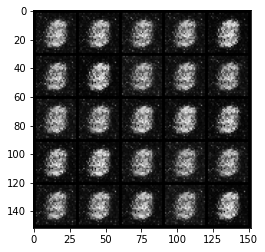

Real images


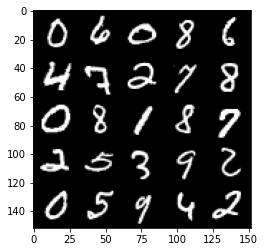


epoch 2


Step 1000: Generator loss: 1.0792178022861494, discriminator loss: 0.523218990921974
Fake images


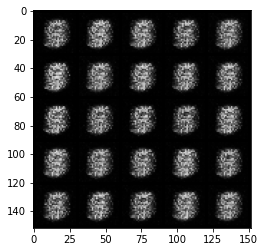

Real images


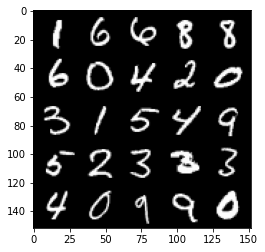


epoch 3


Step 1500: Generator loss: 0.9472664519548422, discriminator loss: 0.5244442701935772
Fake images


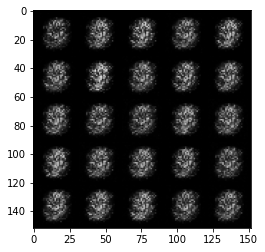

Real images


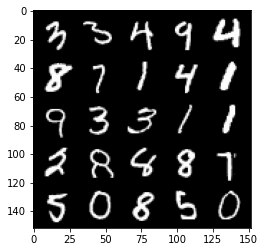


epoch 4


Step 2000: Generator loss: 0.8741161538362502, discriminator loss: 0.49292162746191026
Fake images


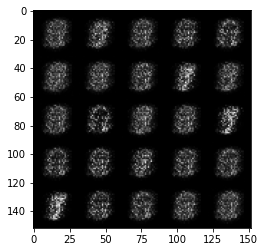

Real images


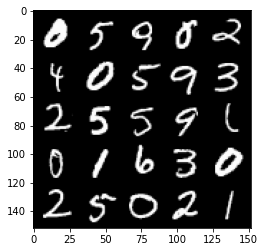


epoch 5


Step 2500: Generator loss: 0.8822497420310986, discriminator loss: 0.4600904508829116
Fake images


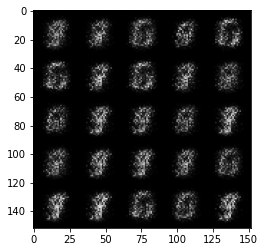

Real images


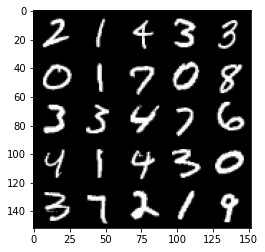


epoch 6


Step 3000: Generator loss: 0.9970299371480941, discriminator loss: 0.4087615068554879
Fake images


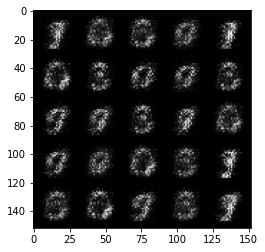

Real images


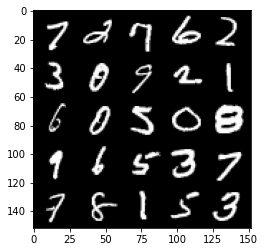


epoch 7


Step 3500: Generator loss: 1.0776260462999345, discriminator loss: 0.39798008680343633
Fake images


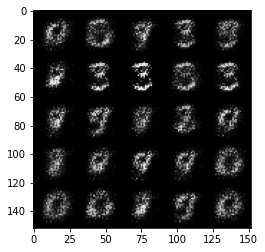

Real images


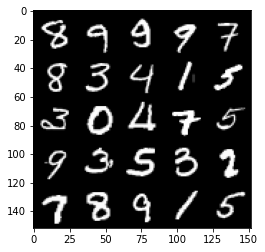


epoch 8


Step 4000: Generator loss: 1.2212220096588138, discriminator loss: 0.3665230628252029
Fake images


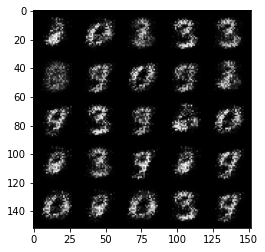

Real images


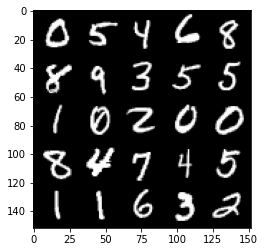


epoch 9


Step 4500: Generator loss: 1.397871417760849, discriminator loss: 0.32969871079921736
Fake images


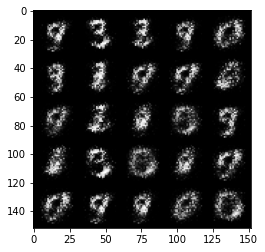

Real images


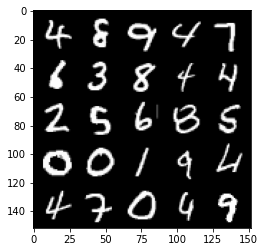


epoch 10


Step 5000: Generator loss: 1.4404440960884106, discriminator loss: 0.36114257544279055
Fake images


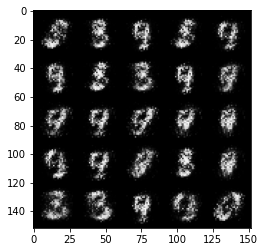

Real images


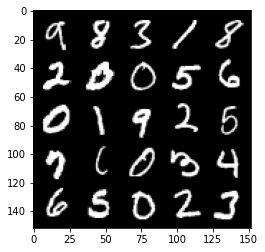


epoch 11


Step 5500: Generator loss: 1.473354104042054, discriminator loss: 0.35578856617212323
Fake images


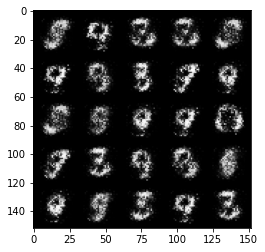

Real images


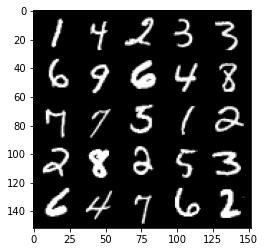


epoch 12


Step 6000: Generator loss: 1.5925495779514318, discriminator loss: 0.3302546633481977
Fake images


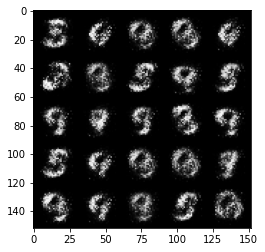

Real images


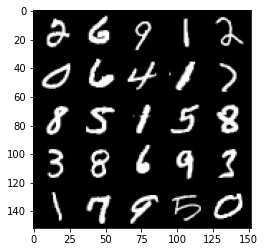


epoch 13


Step 6500: Generator loss: 1.5505262734889986, discriminator loss: 0.34790523654222516
Fake images


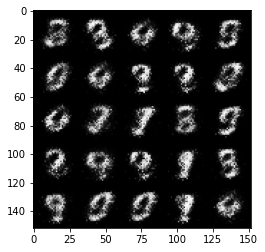

Real images


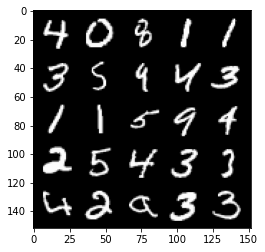


epoch 14


Step 7000: Generator loss: 1.7070228056907657, discriminator loss: 0.2935121058225633
Fake images


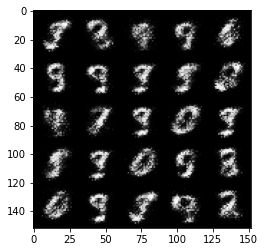

Real images


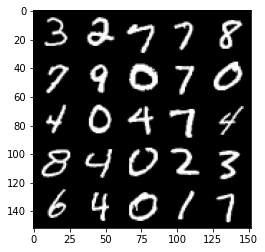


epoch 15


Step 7500: Generator loss: 1.7829073882102968, discriminator loss: 0.2614216049909593
Fake images


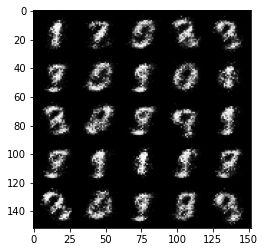

Real images


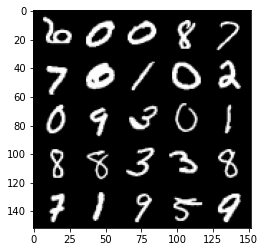


epoch 16



epoch 17


Step 8000: Generator loss: 1.832287835121155, discriminator loss: 0.25219830054044734
Fake images


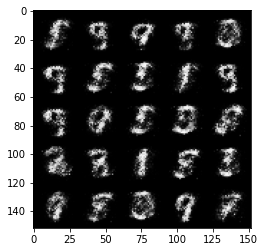

Real images


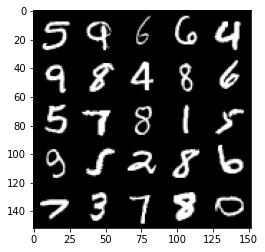


epoch 18


Step 8500: Generator loss: 1.787091294765471, discriminator loss: 0.2772271379232408
Fake images


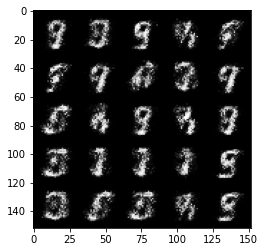

Real images


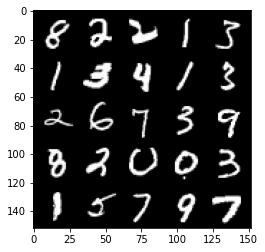


epoch 19


Step 9000: Generator loss: 1.9358594076633446, discriminator loss: 0.25711997976899154
Fake images


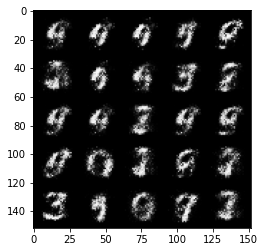

Real images


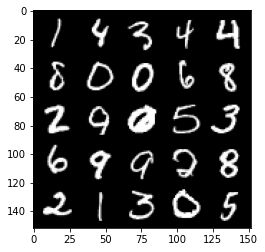

In [13]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True  # Whether the generator should be tested
for epoch in tqdm(range(n_epochs), unit='epoch'):
    print('epoch', epoch)
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader, desc='train'):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ## Update Discriminator ##
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()
        # Calculate discriminator loss
        disc_loss = get_disc_loss(
            gen, disc, criterion, real, cur_batch_size, z_dim, device
        )
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        # For testing purposes, we keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        # Zero out the gradients
        gen_opt.zero_grad()
        # Calculate the generator loss, assigning it to gen_loss
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        # Backprop through the generator (update the gradients and optimizer)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        # We make sure that your code changes the generator weights
        if test_generator:
            assert torch.any(
                gen.gen[0][0].weight.detach().clone() != old_generator_weights
            )

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(
                'Step {}: Generator loss: {}, discriminator loss: {}'.format(cur_step, mean_generator_loss, mean_discriminator_loss)
            )
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            print("Fake images")
            show_tensor_images(fake)
            print("Real images")
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

# Applications:

- Anomaly Detection: e.g. MadGan https://arxiv.org/abs/1901.04997
- Synthetic Data: Use the generator to help in the training, when you don't have enougth data. This is used a lot in medical data where you have few data points. In the end the discrimator
- Adversarial Examples: Are something we may have to harden our models again
- Privacy Preserving: Instead of handing over real patient data
- Super Resolution: Deep Rocks SR